Notebook to share w Stratis

Possible things to discuss/change:
- Resetting synthetic data
- Optimisers/learning rate schedule
- Tradeoff between number of MC samples to estimate gradient at each step and number of steps
- Varying data parameters (e.g. \sigma)

In [15]:
import numpy as np
from scipy.stats.distributions import chi2
from tqdm import tqdm
from scipy.stats import ortho_group
import random
import scipy
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp

In [16]:
def generate_K(x):
    "get kernel matrix from data"
    nb_datapoints = np.shape(x)[0]
    K = np.zeros((nb_datapoints,nb_datapoints))
    for i in range(nb_datapoints):
        for j in range(nb_datapoints):
            K[i,j] = np.exp( - sum((x[i] - x[j])**2) / 2)
    return K

In [17]:
d=4     #dimensionality of data
nb_datapoints = 2       #number of synthetic datapoints to put in Gram matrix used for training
sigma = 0.1     #lengthscale parameter of synthetic data

In [18]:
tfd = tfp.distributions
chi2_dist = tfd.Chi2(d)
norm_dist = tfd.Normal(loc=0.,scale=1.)

In [19]:
# choose the respective orientations of the weights vectors. Below gives you 2d vectors in +- all unit vector directions
basis = np.eye(d)
basis = tf.convert_to_tensor(np.vstack((basis,-basis)), dtype=float)

nb_vecs = len(basis)

In [20]:
class Model(tf.keras.Model):
    "generates and gives ws"
    def __init__(self, initial_thetas):
        #length of initial thetas should be d(2d-1)

        super(Model, self).__init__()
        self.thetas =tf.Variable(np.pi * np.asarray(initial_thetas),dtype=float)

    def call(self,input):  #currently has a dummy input
        thetas = self.thetas
        L = np.ndarray.tolist(np.tril(np.ones((nb_vecs,nb_vecs))))
        counter = 0
        for i in range(nb_vecs-1):
            for j in range(i+1):
                L[i+1][j] *= tf.cos(thetas[counter])
                L[i+1][j+1:] *= tf.sin(thetas[counter])
                counter +=1
        L = tf.convert_to_tensor(L, dtype=float)        #!! Constructing L every time -- can this be done more efficiently?

        eps = tf.random.normal([nb_vecs])
        L_prime = norm_dist.cdf(tf.linalg.matvec(L,eps))
        lengths = tf.sqrt(chi2_dist.quantile(L_prime))
        ws = tf.matmul(tf.linalg.diag(lengths),basis)
        return ws

In [21]:
initial_thetas = np.ones(  int( 0.5 * nb_vecs * (nb_vecs - 1))) * 0.5       #initial parameters for covariance matrix (independent)
get_weights = Model(initial_thetas)

In [22]:
#Generate data and get groundtruth kernel

xs = tf.random.normal(shape = (nb_datapoints,d))
means = tf.reduce_mean(xs,axis=1)
all_means = [means for _ in range(d)]
xs = xs - tf.transpose(tf.stack(all_means))
xs *= sigma
K_groundtruth = generate_K(xs.numpy())

In [23]:
def get_tf_copula_rffs(nb_features,xs, get_weights): 
    "Construct random Fourier features using the weights"
    for feature in range(nb_features):
        ws = get_weights(0)  #get the ws
        rotation = tf.constant(ortho_group.rvs(d), dtype = float)      #get the rotation matrix to apply to all the data
        holder = tf.matmul(ws,tf.matmul(rotation,tf.transpose(xs)))
        cs_holder = tf.concat([tf.cos(holder),tf.sin(holder)],axis=0)
        if feature == 0:
            rfs = cs_holder
        else:
            rfs = tf.concat((tf.reshape(rfs, [feature,2*nb_vecs,len(xs)]),tf.reshape(cs_holder, [1,2*nb_vecs,len(xs)])),axis=0)
    rfs = tf.transpose(tf.reshape(rfs, [nb_features*2*nb_vecs,len(xs)])) / np.sqrt(nb_features * nb_vecs)
    return rfs

def get_tf_copula_prfs(nb_features,xs, get_weights): 
    "Construct positive random features = random Laplace features given the weights"
    for feature in range(nb_features):
        ws = get_weights(0)  #get the ws
        rotation = tf.constant(ortho_group.rvs(d), dtype = float)      #get the rotation matrix to apply to all the data
        holder = tf.matmul(ws,tf.matmul(rotation,tf.transpose(xs)))
        cs_holder = tf.exp(holder)
        if feature == 0:
            rfs = cs_holder
        else:
            rfs = tf.concat((tf.reshape(rfs, [feature,nb_vecs,len(xs)]),tf.reshape(cs_holder, [1,nb_vecs,len(xs)])),axis=0)
    rfs = tf.transpose(tf.reshape(rfs, [nb_features*nb_vecs,len(xs)])) / np.sqrt(nb_features * nb_vecs)
    rfs = tf.linalg.matmul(tf.linalg.diag(tf.exp(-tf.reduce_sum(xs**2,axis=1))), rfs)
    return rfs

In [24]:
def get_rff_loss(nb_features, xs, K_groundtruth, nb_trials, get_weights):
    "Compute average error on gram matrix approx using RFFs"
    loss = 0
    for _ in range(nb_trials):
        rfs = get_tf_copula_rffs(nb_features, xs, get_weights)
        prediction = tf.matmul(rfs,tf.transpose(rfs))
        loss += tf.reduce_sum((tf.constant(K_groundtruth, dtype=float) - prediction)**2) / tf.reduce_sum((tf.constant(K_groundtruth, dtype=float) )**2)
    return loss / nb_trials

def get_prf_loss(nb_features, xs, K_groundtruth, nb_trials, get_weights):
    "Compute average error on graph matrix approx using PRFs"
    loss = 0
    for _ in range(nb_trials):
        rfs = get_tf_copula_prfs(nb_features, xs, get_weights)
        prediction = tf.matmul(rfs,tf.transpose(rfs))
        loss += tf.reduce_sum((tf.constant(K_groundtruth, dtype=float) - prediction)**2) / tf.reduce_sum((tf.constant(K_groundtruth, dtype=float) )**2)
    return loss / nb_trials


In [25]:
epochs = 100        #number of epochs to optimise for
grad_log = []
nb_trials = 100     #number of MC samples to compute loss
nb_features = 1     #length of PRFs/RFFs (1 is fine)

initial_lr = 20000
lrs = np.exp(np.linspace(np.log(initial_lr),np.log(10),epochs))

loss_log = []

for epoch in range(epochs):
    print('epoch: %s' % (epoch+1))
    
    with tf.GradientTape() as tape:
        #loss = get_rff_loss(nb_features, xs, K_groundtruth, nb_trials, get_weights)        #If training RFFs
        loss = get_prf_loss(nb_features, xs, K_groundtruth, nb_trials, get_weights)         #If training PRFs
        loss_log.append(loss)
    
    print('loss: %s'%(loss.numpy()))

    grad = tape.gradient(loss,get_weights.trainable_variables)
    #optimiser = tf.keras.optimizers.SGD(learning_rate = lrs[epoch])
    optimiser = tf.keras.optimizers.Adam(learning_rate = lrs[epoch])
    optimiser.apply_gradients(zip(grad,get_weights.trainable_variables))
   


epoch: 1


loss: 0.0009403721
epoch: 2
loss: 0.0003611681
epoch: 3
loss: 0.00084380916
epoch: 4
loss: 0.000553823
epoch: 5
loss: 0.0012819117
epoch: 6
loss: 0.0011502112
epoch: 7
loss: 0.0013911953
epoch: 8
loss: 0.00096651795
epoch: 9
loss: 0.0015838309
epoch: 10
loss: 0.0016356215
epoch: 11
loss: 0.00092797296
epoch: 12
loss: 0.0010043991
epoch: 13
loss: 0.0007360101
epoch: 14
loss: 0.00072029675
epoch: 15
loss: 0.0010521616
epoch: 16
loss: 0.0012469933
epoch: 17
loss: 0.0010219805
epoch: 18
loss: 0.0009495167
epoch: 19
loss: 0.001585845
epoch: 20
loss: 0.001164869
epoch: 21
loss: 0.00087386154
epoch: 22
loss: 0.0019662417
epoch: 23
loss: 0.0009650923
epoch: 24
loss: 0.0004873408
epoch: 25
loss: 0.0007186037
epoch: 26
loss: 0.0010306138
epoch: 27
loss: 0.0009178488
epoch: 28
loss: 0.00068822474
epoch: 29
loss: 0.0015611904
epoch: 30
loss: 0.0009791595
epoch: 31
loss: 0.0006667074
epoch: 32
loss: 0.0007566743
epoch: 33
loss: 0.0010421794
epoch: 34
loss: 0.0009821089
epoch: 35
loss: 0.0007139702


Text(0.5, 1.0, 'RLF learned covariance matrix')

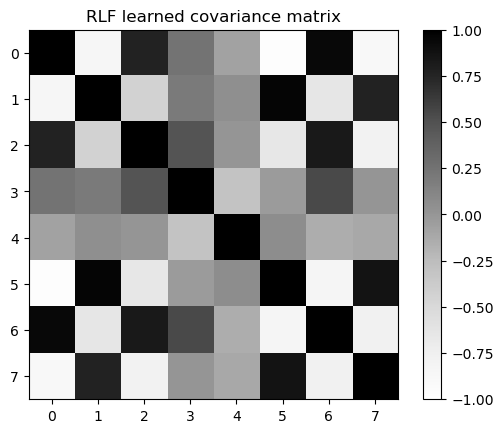

In [30]:
#Retrieve learned weights and plot covariance matrix

thetas= get_weights.trainable_variables[0].numpy()
#thetas = np.pi / 2 * np.ones((15))

L = np.ndarray.tolist(np.tril(np.ones((nb_vecs,nb_vecs))))
counter = 0
for i in range(nb_vecs-1):
    for j in range(i+1):
        L[i+1][j] *= tf.cos(thetas[counter])
        L[i+1][j+1:] *= tf.sin(thetas[counter])
        counter +=1
L = tf.convert_to_tensor(L, dtype=float).numpy()
M = L @ L.T
plt.imshow(M, cmap = 'Greys',vmin=-1, vmax=1)
plt.colorbar()
plt.title(r'RLF learned covariance matrix')
#plt.savefig('RLF_learned_cov_plot.pdf')


Text(0.5, 0, 'Epochs')

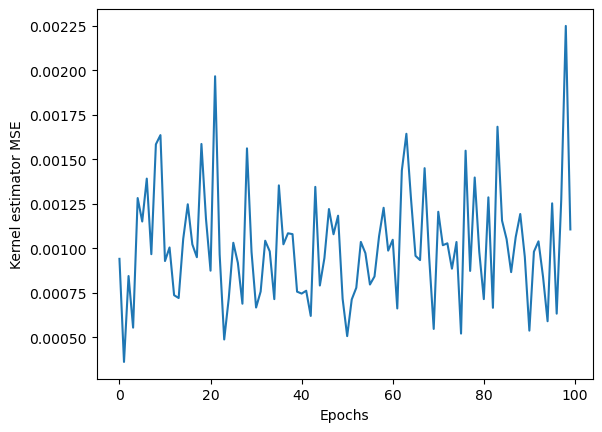

In [29]:
#Plot training curve
plt.plot(tf.convert_to_tensor(loss_log).numpy())
plt.ylabel('Kernel estimator MSE')
plt.xlabel('Epochs')
